# Исследование закономерности успешности компьютерных игр

Задача: выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.\
Заказчик: интернет-магазин «Стримчик», который продаёт по всему миру компьютерные игры
Исходные данные: исторические данные из открытых источников о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).


## Изучение данных из файла

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

Прочитаем файл с информацией и посмотрим 10 случайных строк и общую информацию

In [2]:
data = pd.read_csv('Ya_data/games.csv')

data.sample(10, random_state = 1)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
14230,Rakushou! Pachi-Slot Sengen 5: Rio Paradise,PS2,2007.0,Misc,0.00,0.00,0.03,0.00,NaN,NaN,NaN
14043,Nobunaga's Ambition II,3DS,2015.0,Strategy,0.00,0.00,0.04,0.00,NaN,NaN,NaN
3158,Up,DS,2009.0,Action,0.30,0.27,0.00,0.07,NaN,tbd,E
22,Super Mario Bros. 3,NES,1988.0,Platform,9.54,3.44,3.84,0.46,NaN,NaN,NaN
110,Mario Kart 8,WiiU,2014.0,Racing,3.15,2.15,1.28,0.51,88.0,9.1,E
1988,ATV: Quad Power Racing,PS,2000.0,Racing,0.58,0.39,0.00,0.07,42.0,tbd,E
7130,64 de Hakken! Tamagotchi Minna de Tamagotchi W...,N64,1997.0,Misc,0.00,0.00,0.22,0.00,NaN,NaN,NaN
8849,Derby Stallion 64,N64,2001.0,Sports,0.00,0.00,0.15,0.00,NaN,NaN,NaN
14602,Star Wars: The Force Unleashed II,PC,2010.0,Action,0.03,0.00,0.00,0.00,59.0,5.8,T
106,Tekken 3,PS,1998.0,Fighting,3.27,2.22,1.40,0.29,96.0,9.1,T


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
data.isna().mean().sort_values() #поcмотрим относительное количество пропусков в столбцах

Platform           0.000000
NA_sales           0.000000
EU_sales           0.000000
JP_sales           0.000000
Other_sales        0.000000
Name               0.000120
Genre              0.000120
Year_of_Release    0.016093
User_Score         0.400897
Rating             0.404786
Critic_Score       0.513192
dtype: float64

### Вывод

Из общей информации видно, что: 
Данные содержат 16715 строк и 11 столбцов:
Name — название игры\
Platform — платформа\
Year_of_Release — год выпуска\
Genre — жанр игры\
NA_sales — продажи в Северной Америке (миллионы проданных копий)\
EU_sales — продажи в Европе (миллионы проданных копий)\
JP_sales — продажи в Японии (миллионы проданных копий)\
Other_sales — продажи в других странах (миллионы проданных копий)\
Critic_Score — оценка критиков (максимум 100)\
User_Score — оценка пользователей (максимум 10)\
Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Name и Genre имеют 2 пропуска; Critic_Score, User_Score и Rating имеют 40 - 50 % пропусков; Year_of_Release имеет около 2%  пропусков\
User_Score имеет неверный формат

## Подготовка данных

### Приведем названия столбцов к нижнему регистру

In [5]:
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Преобразуем данные в нужные типы

Преобразуем данные в столбце user_score в числовые. В столбце user_score имеется аббревиатура tbd которая переводится как "Подлежит определению", т.е это пропуски. Таких значений 2424. Заменим их на NaN.

In [6]:
data.loc[data['user_score'] == 'tbd']['user_score'].count()

2424

In [7]:
data['user_score'] = pd.to_numeric(data['user_score'], errors = 'coerce')
data.dtypes

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
dtype: object

### Обработка пропусков

Посмотрим данные с пропусками по year_of_release. 

Часть игр содержит в своем названии  год, который может отличастся с годом релиза на 1 год, но всеже лучше чем медиана.

Извлечем эту информацию

In [8]:
year_by_name = data[data['year_of_release'].isnull()]['name'].str.extract('([0-9]{4})').dropna().astype(float)
year_by_name

,0
183,2004.0
377,2004.0
475,2006.0
1650,2003.0
2572,2009.0
3486,2002.0
4775,2003.0
5156,2003.0
5336,2013.0
5655,2005.0


Посмотрим что мы нашли. В основном это спортивные симуляторы, которые выходят в год названия, или годом ранее. Некоторые названия повторияются, это теже игры на разных платформах.

In [9]:
data.loc[year_by_name.index, ['name', 'platform']]

,name,platform
183,Madden NFL 2004,PS2
377,FIFA Soccer 2004,PS2
475,wwe Smackdown vs. Raw 2006,PS2
1650,NASCAR Thunder 2003,PS2
2572,PES 2009: Pro Evolution Soccer,PSP
3486,Madden NFL 2002,XB
4775,NFL GameDay 2003,PS2
5156,NBA Live 2003,XB
5336,Tomb Raider (2013),PC
5655,All-Star Baseball 2005,PS2


Заменим пропуски на года из названия.

In [10]:
data.loc[year_by_name.index, 'year_of_release'] = year_by_name.values

In [11]:
data.isna().mean().sort_values()

platform           0.000000
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
name               0.000120
genre              0.000120
year_of_release    0.015076
rating             0.404786
critic_score       0.513192
user_score         0.545917
dtype: float64

Колличество пропусков year_of_release немного сократилось. С остальными пропусками ничего не поделать. Пропуски в оценке пользователей и критиков слишком непредсказуемы. 

### Суммарные продажи во всех регионах 

In [12]:
# Суммарные продажи запишем в новый столбец total_sales
data['total_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


### Вывод

Преобразовали данные. Заполнили немного пропусков в годах релиза. Посчитали суммарные продажи во всех регионах.

## Исследовательский анализ данных

### Распределение игр по годам

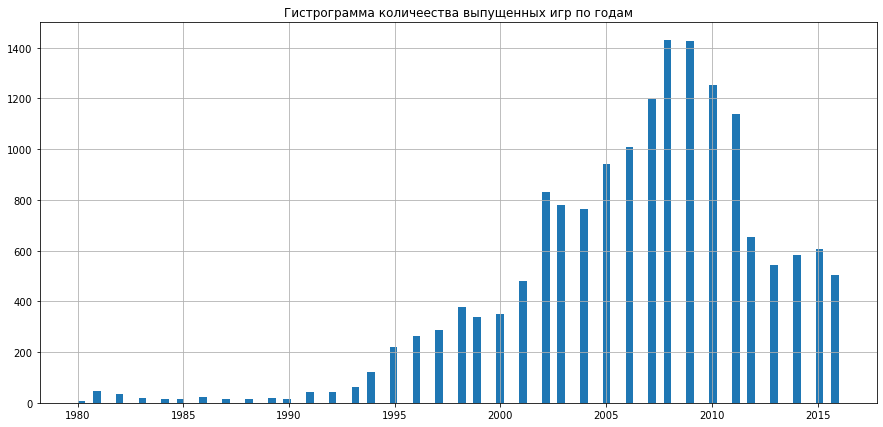

In [13]:
data['year_of_release'].hist(bins=100, figsize=(15,7))
plt.title('Гистрограмма количеества выпущенных игр по годам')
plt.show()

С 1995 года наблюдается резкий рост числа выпущеных игр.

### Платформы с наибольшими суммарными продажами

Построим рейтинг платформ по суммарным продажам. 

In [14]:
platform_top = data.groupby('platform')['total_sales'].sum().sort_values(ascending = False).head(10)
platform_top

platform
PS2     1255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.12
PS       730.86
GBA      317.85
PS4      314.14
PSP      294.05
PC       259.52
Name: total_sales, dtype: float64

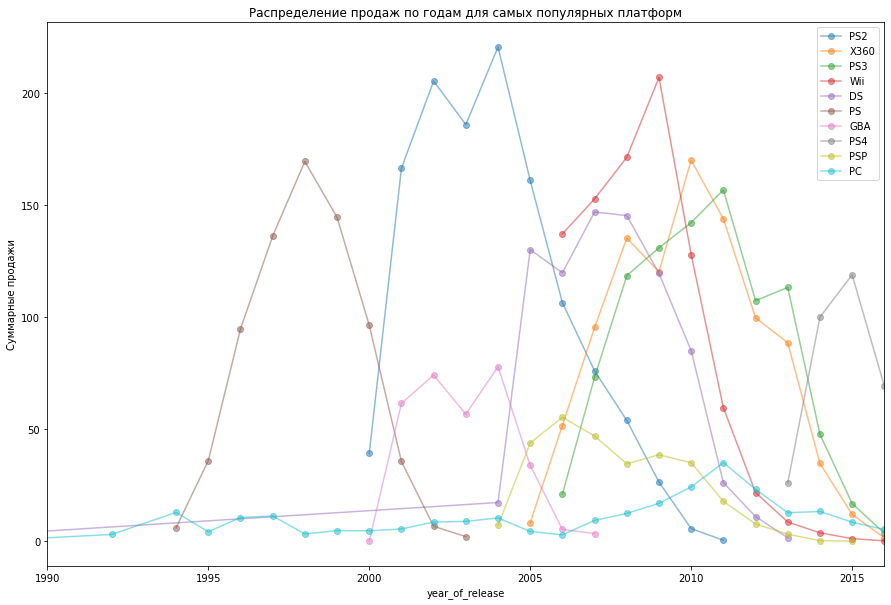

In [15]:
fig, ax = plt.subplots()

for i in platform_top.index:
    data.loc[data['platform'] == i].groupby('year_of_release')['total_sales'].sum()\
    .plot(ax = ax, label = i, figsize=(15,10), alpha = 0.5, style='o-')

ax.set_title('Распределение продаж по годам для самых популярных платформ')
plt.xlim([1990, 2016])
ax.set_ylabel('Суммарные продажи')
plt.legend()
#plt.title('Распределение продаж по годам для самых популярных платформ')

plt.show()

Судя по графику время жизни платформы 5-10 лет. За актуальный возьмем период 2007 - 2016 гг.
У DS можно заметить артефакт. Игра 1985 года. Консоль вышла в 2004.

In [16]:
data_actual = data.query('year_of_release >= 2012') #выкинем лишние данные

### Потенциально прибыльные платформы

Посмотрим какие платформы растут или падают среди лидеров за последние 5 лет и выберем потенциально прибыльные.

In [17]:
Potentially_platform_top = data_actual.groupby('platform')['total_sales']\
.sum().sort_values(ascending = False).head(7)
Potentially_platform_top

platform
PS4     314.14
PS3     288.79
X360    236.54
3DS     194.61
XOne    159.32
WiiU     82.19
PC       63.00
Name: total_sales, dtype: float64

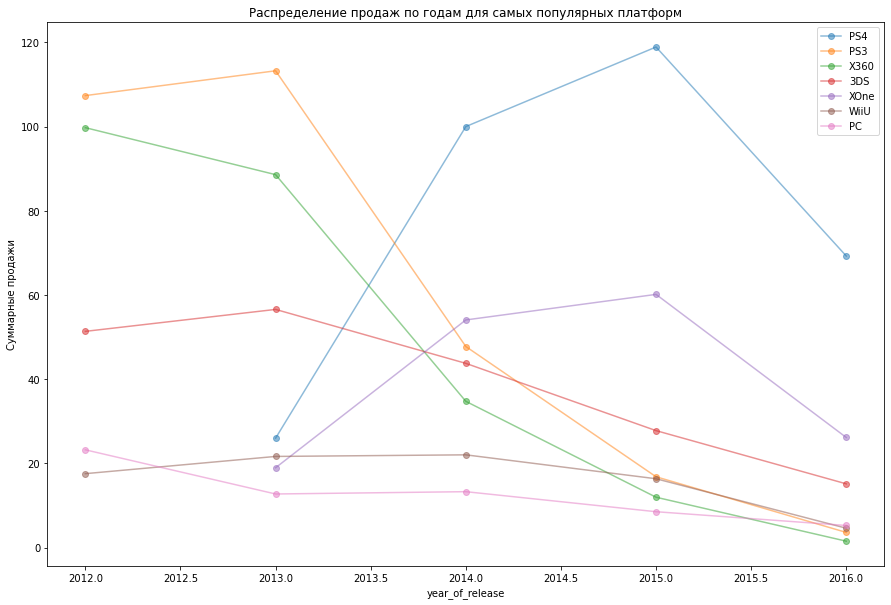

In [18]:
fig, ax = plt.subplots()

for i in Potentially_platform_top.index:
    data_actual.loc[data_actual['platform'] == i].groupby('year_of_release')['total_sales']\
    .sum().plot(ax = ax, label = i, figsize=(15,10), alpha = 0.5, style = 'o-')

ax.set_title('Распределение продаж по годам для самых популярных платформ')
ax.set_ylabel('Суммарные продажи')
plt.legend()
plt.show()

В 2013 годау произошла смена поколений. 2 Растущие поалтформы PS4 и XOne, которые пришли на смену PS3 и X360 соответсвенно. Падение в 2016 году видимо связато с тем, что данные по нему не полные. 

### «ящик с усами» по глобальным продажам игр

In [19]:
data_actual = data_actual.query("platform == @Potentially_platform_top.index.to_list()") #выкинем лишние данные

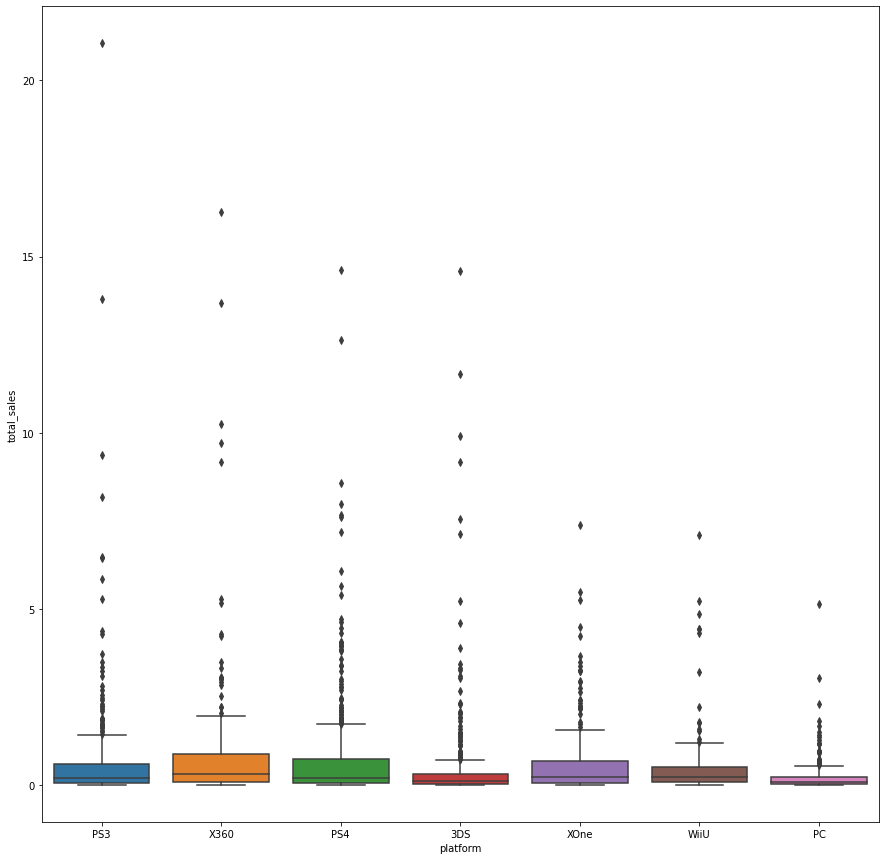

In [20]:
#построим ящик с усами
ax = plt.subplots(figsize=(15,15))
ax = sns.boxplot(x="platform", y="total_sales", data=data_actual)

PS3 и X360 показывают примерно одинаковые медианные значения, как и пришедшие им на смену PS4 и XOne. Выбросы это хитовые игры бьющие рекорды продаж. Тут PS4 обганяет XOne.

### Влияние отзывов на продажи внутри платформы

Рассмотрим как влияют отзывы пользователей и критиков на продажи на примере популярной платформы PS3

In [21]:
def sales_dep_by_patform(platform_name):
    platform_data = data_actual.query("platform == @platform_name")
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
    platform_data.plot(x='critic_score', y='total_sales', kind='scatter', alpha = 0.2, title = 'Зависимость продаж от отзывов критиков', ax=ax1)
    platform_data.plot(x='user_score', y='total_sales', kind='scatter', alpha = 0.2, title = 'Зависимость продаж от отзывов пользователей',ax=ax2)
    print('Коэффициент корреляции для отзывов критиков:{:.2f}' .format(platform_data['critic_score'].corr(platform_data['total_sales'])))
    print('Коэффициент корреляции для отзывов пользователей:{:.2f}' .format(platform_data['user_score'].corr(platform_data['total_sales'])))

Коэффициент корреляции для отзывов критиков:0.33
Коэффициент корреляции для отзывов пользователей:-0.01


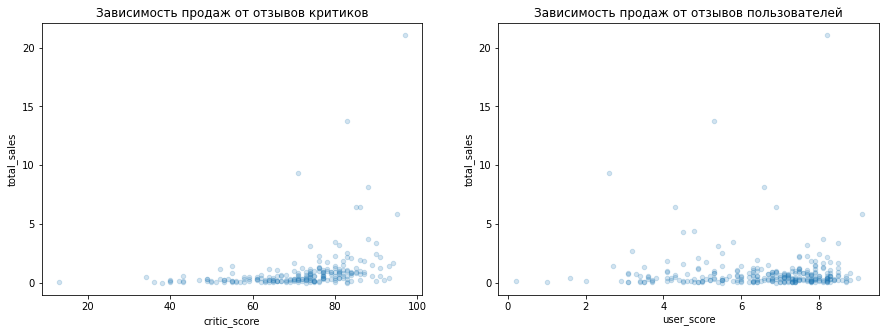

In [22]:
sales_dep_by_patform('PS3')

Высокие оценки критиков гораздо сильнее повышают продажи продажи нежели высокие оценки пользователей.

### Соотношение выводов с продажами игр на других платформах

Соотнесем выводы с продажами игр на других платформах. Рассмотрим зависимости на платформах PS4 и XOne

Коэффициент корреляции для отзывов критиков:0.41
Коэффициент корреляции для отзывов пользователей:-0.03


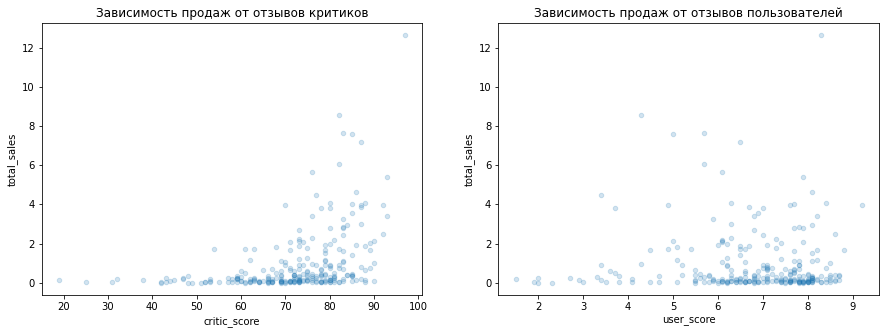

In [23]:
sales_dep_by_patform('PS4')

Коэффициент корреляции для отзывов критиков:0.42
Коэффициент корреляции для отзывов пользователей:-0.07


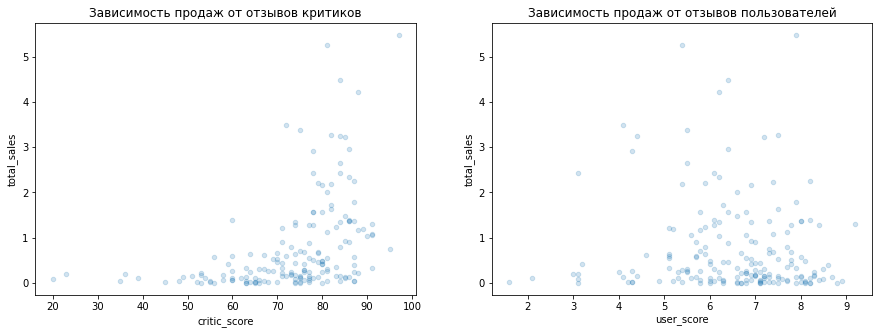

In [24]:
sales_dep_by_patform('XOne')

В других группах наблюдается аналогичная ситуация.

###  Общее распределение игр по жанрам

<AxesSubplot:title={'center':'Распределение игр по жанрам (общее колличество продаж)'}, xlabel='genre'>

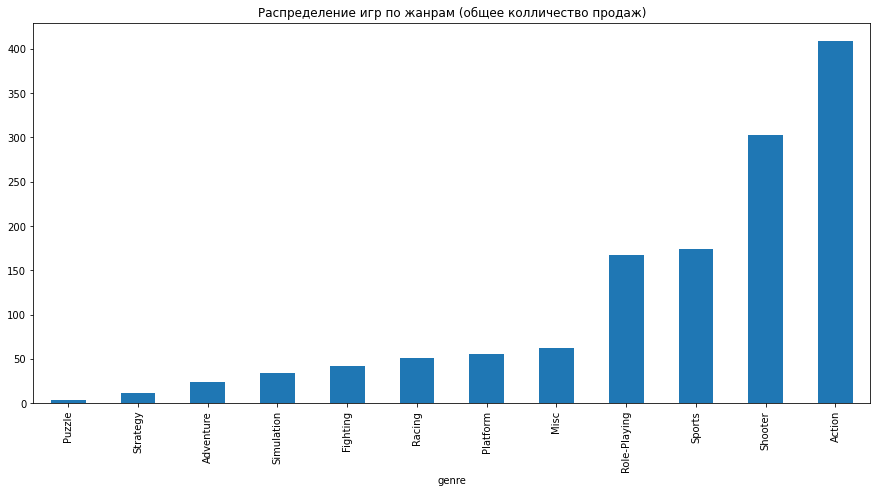

In [25]:
data_actual.groupby('genre')['total_sales'].sum().sort_values().plot(kind = 'bar', figsize=(15,7), title = 'Распределение игр по жанрам (общее колличество продаж)')

Саммые прибыльные жанры Action, Shooter, Sports.  Самые низкие продпжи в жанрах Puzzle, Strategy, Adventure

### Вывод

Ограничили актуальный временной период анализа 2007-2016гг исходя из того что время жизни платформы 5-10 лет. Смена поколений платформ произошла в 2013 году. Растущие платформы PS4 и XOne заменяют падающие PS3 и X360 соответсвенно. На увеличение продаж сильно влияют высокие оценки критиков. Наиболее популярные жанры экшен и шутер.

## Портрет пользователя каждого региона

In [26]:
def popular_by_region(param_name, title):
    
    fig, axes = plt.subplots(ncols=3, figsize=(17,6))
    for region, label, ax in [('na_sales', 'в Северной Америке:',axes[0]),
                             ('eu_sales', 'в Европе:',axes[1]),
                             ('jp_sales', 'в Японии:',axes[2])]:
        data_actual.groupby(param_name)[region].sum().sort_values(ascending = False).head(5)\
        .plot(kind = 'pie', autopct='%1.0f%%',ax=ax, ylabel='')
        ax.set_title(label)
    fig.suptitle(title)
    plt.show()

### Самые популярные платформы (топ-5)

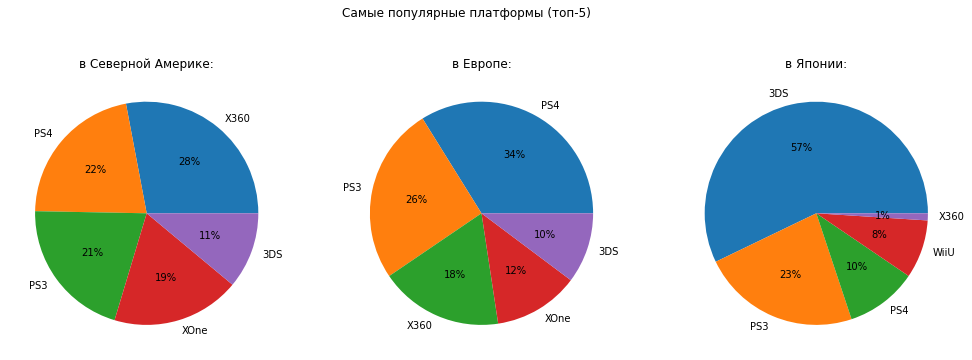

In [27]:
popular_by_region('platform', 'Самые популярные платформы (топ-5)')

В Северной Америке и Европе рынок делят платформы от Microsoft (X360, XOne) и Sony(PS3 и PS4). В Японии на первых местах домашние платформы (3DS, PS3, PS4, WiiU). 

### Самые популярные жанры (топ-5)

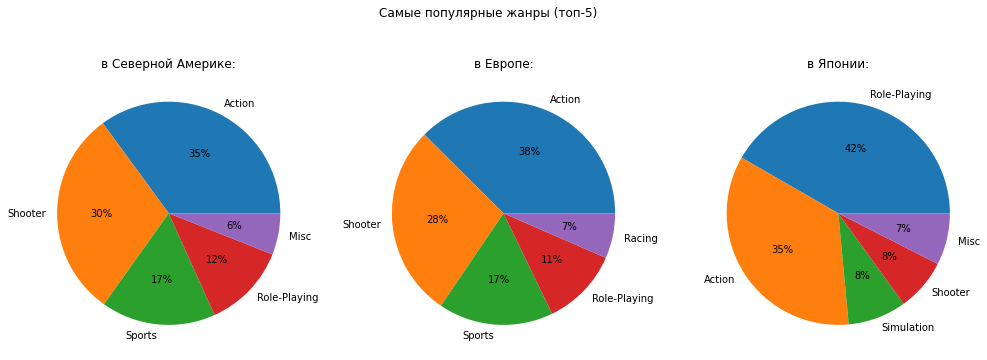

In [28]:
popular_by_region('genre', 'Самые популярные жанры (топ-5)')

В Северной Америке и Европе больше игреют в экшены, шутеры, спроотвные и ролевые игры. В японии основную долю занимают ролевые игры и экшен. Разные ивилизации - разные интересы.

### Влияние рейтинга ESRB на продажи в отдельном регионе (топ-5)

In [29]:
data_actual['rating'] = data_actual['rating'].fillna('NR') # Пометим пропуски NR - NotRated

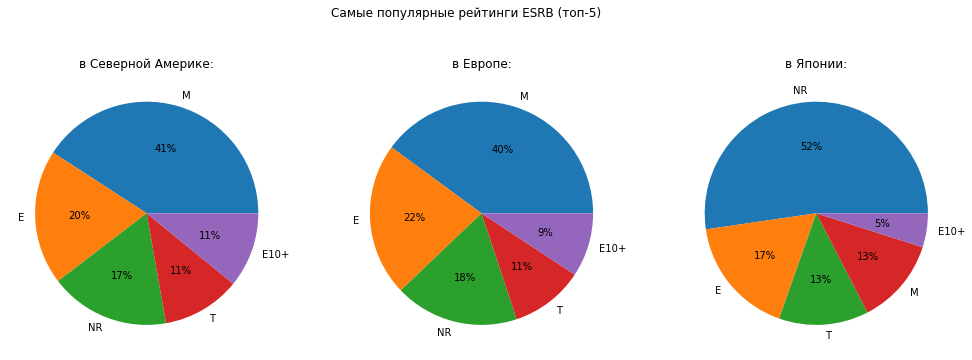

In [30]:
popular_by_region('rating', 'Самые популярные рейтинги ESRB (топ-5)')

В Северной Америке и Европе распределение долей почти одинаковое. Самую большую долю составляют игры с отметкой "для взрослых", потом идут "для всех", "без рейтинга", "для подростков" и "для всех от 10 лет". В японии картина отличется. Больше половинв игр тут продается "без рейтинга". Далее 3 рейтинга распределены почти в равных пропорциях. Видимо эта рейтинговая система не пользуется спросом в Японии.

### Вывод

**Портрет пользрвателя Северной америки и Европы**\
Платформа: X360, XOne, PS3, PS4.\
Жанр:Экшен, шутер\
Ретинг ESRB: "для всзрослых"\
\
**Портрет пользрвателя Японии**\
Платформа: 3DS, PS3, PS4.\
Жанр: Ролевая, Экшен\
Ретинг ESRB: "Без рейтинга"

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

In [31]:
## Сформируем сравниваемыеаемые выборки
sample_XOne = data_actual[(data_actual['platform'] == 'XOne')]['user_score']
sample_PC = data_actual[(data_actual['platform'] == 'PC')]['user_score']

Посчитаем средний пользовательский рейтинг, его дисперсию и стандартное отклонение для платформы XOne

In [32]:
sample_XOne.agg(['mean', 'var', 'std'])

mean    6.521429
var     1.906997
std     1.380941
Name: user_score, dtype: float64

Посчитаем средний пользовательский рейтинг, его дисперсию и стандартное отклонение для платформы PC

In [33]:
sample_PC.agg(['mean', 'var', 'std'])

mean    6.438647
var     2.777722
std     1.666650
Name: user_score, dtype: float64

Построим гистрограммы для пользовательского рейтинга

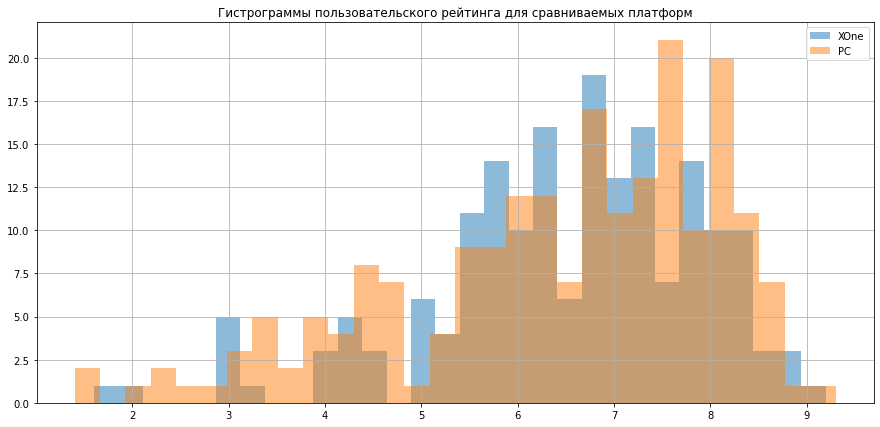

In [34]:
sample_XOne.hist(bins = 30, figsize=(15,7), alpha = 0.5)
sample_PC.hist(bins = 30, figsize=(15,7), alpha = 0.5)
plt.title('Гистрограммы пользовательского рейтинга для сравниваемых платформ')
plt.legend(['XOne', 'PC'])
plt.show()

Сформулируем гипотезы:\
Среднийе пользовательские рейтинги для платформ XOne и PC равны - нулевая гипотеза Н0\
Среднийе пользовательские рейтинги для платформ XOne и PC различны - альтернативная гипотеза Н1

In [35]:
# Проверка гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам
alpha = 0.01 #Уровень значимости
results = st.ttest_ind(sample_XOne, sample_PC, nan_policy = 'omit' , equal_var = False) 
results.pvalue

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5926118514134983
Не получилось отвергнуть нулевую гипотезу


### Средние пользовательские рейтинги жанров Action и Sports разные

In [36]:
## Сформируем срантваемые выборки
sample_Action = data_actual[data_actual['genre'] == 'Action']['user_score']
sample_Sports = data_actual[data_actual['genre'] == 'Sports']['user_score']

Посчитаем средний пользовательский рейтинг, его дисперсию и стандартное отклонение для жанра Action

In [37]:
sample_Action.agg(['mean', 'var', 'std'])

mean    6.811915
var     1.812694
std     1.346363
Name: user_score, dtype: float64

Посчитаем средний пользовательский рейтинг, его дисперсию и стандартное отклонение для жанра Sports

In [38]:
sample_Sports.agg(['mean', 'var', 'std'])

mean    5.420879
var     2.890280
std     1.700082
Name: user_score, dtype: float64

Построим гистрограммы для пользовательского рейтинга

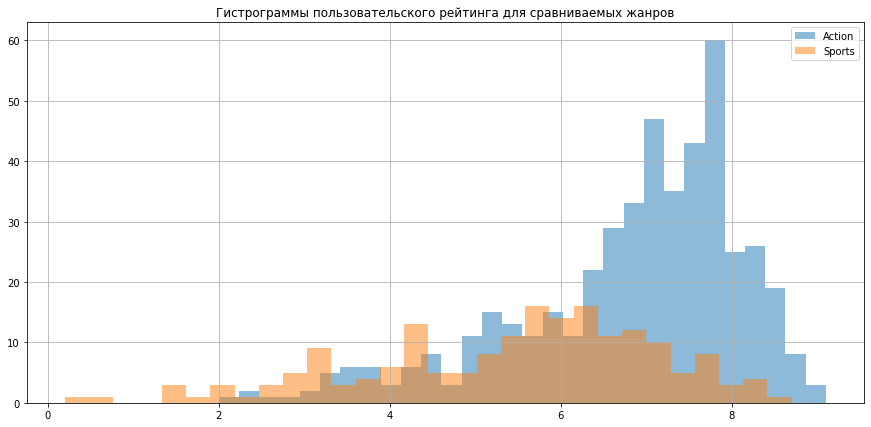

In [39]:
sample_Action.hist(bins = 30, figsize=(15,7), alpha = 0.5)
sample_Sports.hist(bins = 30, figsize=(15,7), alpha = 0.5)
plt.title('Гистрограммы пользовательского рейтинга для сравниваемых жанров')
plt.legend(['Action', 'Sports'])
plt.show()

Сформулируем гипотезы:\
Среднийе пользовательские рейтинги для жанров Action и Sports равны - нулевая гипотеза Н0\
Среднийе пользовательские рейтинги для жанров Action и Sports различны - альтернативная гипотеза Н1

In [40]:
# Проверка гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам
alpha = 0.01 #Уровень значимости
results = st.ttest_ind(sample_Action, sample_Sports, nan_policy = 'omit', equal_var = False) #Дисперсии сильно отличаются
results.pvalue

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.965036450010899e-20
Отвергаем нулевую гипотезу


### Вывод

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые\
Средние пользовательские рейтинги жанров Action и Sports разные

## Общий вывод

Основные результаты исследования:\
Время жизни платформы 5-10 лет.\
В 2013 году произошла смена поколений платформ. \
Растущие платформы PS4 и XOne заменяют падающие PS3 и X360 соответсвенно. Основную ставку следует сделать на новые платформы. Но устаревающие платформы занимают еще значительную долю рынка.\
На увеличение продаж сильно влияют высокие оценки критиков.\
Наиболее популярные жанры экшен и шутер.\
Большинство продаваемых игр (~40%)  имеет рейтинг "для взрослых"

Для японского рынка есть некоторые особенности:\
Здесь больше половины продаж занимает платформа 3DS, остальную часть занимают PS3, PS4 и WiiU\
Наиболее популярные жанры экшен и ролевые игры.\
Система рейтингов видимо не пользуется тут популярностью. Больше половины игр продается без рейтинга.


Проверка гипотез показала, что с высоким уронем значимости 1%:\
Средние пользовательские рейтинги платформ Xbox One и PC одинаковые\
Средние пользовательские рейтинги жанров Action и Sports разные
